<a href="https://colab.research.google.com/github/Arnish-B/spamtitan/blob/master/nlp_lr_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [3]:
#Just some example text to train the model ( SMS Messages )
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [5]:
# importing and initializing countVector ( with default parameters ) 
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [8]:
vect.fit(simple_train)

CountVectorizer()

In [10]:
# check the fit vocabulary
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [11]:
# we here change the training data into a matrix form - a 'document-term matrix' 
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [12]:
# matrix sparse to dense
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [14]:
# combining both, the vocabulary and the document-term matrix together to create a visual 
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [15]:
#  type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [16]:
# sparse matrix contents:
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


In [17]:
# example text for model testing
simple_test = ["please don't call me"]

In [18]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [20]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


In [22]:
# reading our dataset into pandas
sms = pd.read_csv("/content/spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [48]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes usf lives around though


In [52]:
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,message_len,clean_msg,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts 21s...,1
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes usf lives around though,0


In [26]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Text(0.5, 0, 'Message Length')

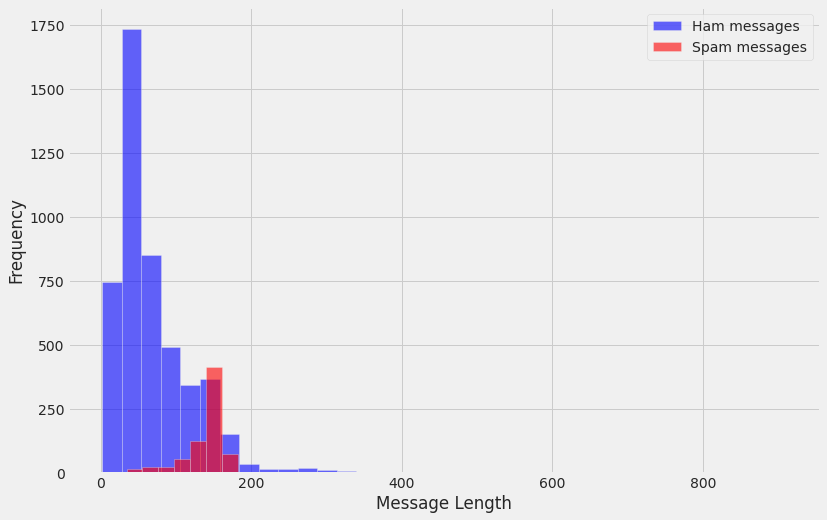

In [27]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [49]:
#details about all messages labelled "ham"
sms[sms.label=='ham'].describe()

,message_len
count,4825.000000
mean,71.023627
std,58.016023
min,2.000000
25%,33.000000
50%,52.000000
75%,92.000000
max,910.000000


In [50]:
# we see that one text above is unusually large ( 910 characters - we can display that text if needed ( so that we do not confuse it for spam ))

# details about all messages labelled "spam"
sms[sms.label=='spam'].describe()

,message_len
count,747.000000
mean,138.866131
std,29.183082
min,13.000000
25%,132.500000
50%,149.000000
75%,157.000000
max,224.000000


In [39]:
"""
the below code performs 3 operations:
1. removes all punctuations
2. removes all stopwords 
3. returns a list of the cleansed words

"""


import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def text_process(mess):

    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
sms.head()

,label,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [41]:
# tokenizing the text

sms['clean_msg'] = sms.message.apply(text_process)

In [43]:
# displaying cleaned messages in comparison to the initial messages
sms.head()

,label,message,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes usf lives around though


In [44]:
type(stopwords.words('english'))

list

In [45]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94)]


In [46]:
words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


In [53]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [54]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [55]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [56]:
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

In [57]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [58]:
# examine the document-term matrix
X_train_dtm

<4179x7996 sparse matrix of type '<class 'numpy.int64'>'
	with 34796 stored elements in Compressed Sparse Row format>

In [59]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7996 sparse matrix of type '<class 'numpy.int64'>'
	with 9971 stored elements in Compressed Sparse Row format>

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

In [61]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [62]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 6.34 ms, sys: 0 ns, total: 6.34 ms
Wall time: 27.1 ms


MultinomialNB()

In [63]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [64]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9827709978463748

In [65]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1205,    8],
       [  16,  164]])

In [66]:
X_test.shape

(1393,)

In [67]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==0)]
X_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
1289    HeyGreat dealFarm tour 9am 5pm 95pax 50 deposi...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [68]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

In [69]:
# example of false negative 
X_test[4949]

'Hi probably much fun get message thought id txt cos bored james farting night'

In [70]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.11903975e-02, 3.97831612e-04, 1.06470895e-03, ...,
       1.31939653e-02, 9.99821127e-05, 6.04083365e-06])

In [71]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9774342768159751

In [72]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [73]:
y_pred = pipe.predict(X_test)

In [74]:
metrics.accuracy_score(y_test, y_pred)

0.9669777458722182

In [75]:
metrics.confusion_matrix(y_test, y_pred)

array([[1213,    0],
       [  46,  134]])

In [76]:
# import an instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [77]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 23.2 ms, sys: 729 µs, total: 24 ms
Wall time: 32 ms


LogisticRegression(solver='liblinear')

In [78]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [79]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01694418, 0.0152182 , 0.08261755, ..., 0.02198942, 0.00531726,
       0.00679188])

In [80]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9842067480258435

In [81]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[1213,    0],
       [  22,  158]])

In [82]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9835714940001832